In [1]:
'''
Unsupervised k-means clustering on standardized and cleaned plain text file versions of EEBO-TCP texts. 

Produces a user-specified number of clusters based on term frequency vectorization. 
These clusters are described using the keywords found in their corresponding entries 
in a metadata CSV file made using metadata.py in Stage I. 

The vectorize and cluster functions are adapted from the EarlyPrint Lab: 
    https://earlyprint.org/jupyterbook/unsupervised.html
The topTerms function is adapted from 
    https://pythonprogramminglanguage.com/kmeans-text-clustering/ 
The elbow and intercluster functions are adapted from Yellowbrick's documentation: 
    https://www.scikit-yb.org/en/latest/index.html
'''
import numpy as np
import pandas as pd
from collections import defaultdict,Counter
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('ggplot')


def vectorize(strings,ids,option):
    '''
    Vectorizes the texts and returns a dataframe of texts mapping to their TCP IDs. 
    '''
    # vector = TfidfVectorizer(min_df=2, sublinear_tf=True)
    # results = vector.fit_transform(strings)
    if option =='count': vector = CountVectorizer()
    else: vector = TfidfVectorizer()
    results = vector.fit_transform(strings)
    df = pd.DataFrame(results.toarray(), index=ids, columns=vector.get_feature_names_out()) # Convert information back to a DataFrame
    return df

def cluster(df,ids,num):
    model = KMeans(n_clusters=num, random_state=42) 
    model.fit(df) 
    kmeans_groups = defaultdict(list)
    for k,v in zip(model.labels_,ids):
        kmeans_groups[k].append(v)
    return kmeans_groups,model

def topTerms(model,df,num):
    tops = {}
    centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = list(df.columns)
    for i in range(num):
        tops[i] = []
        for ind in centroids[i, :20]:
            tops[i].append(terms[ind])
    return tops 

def elbow(df):
    from yellowbrick.cluster.elbow import kelbow_visualizer
    kelbow_visualizer(KMeans(), df, k=(2, 10),timings=False)
    # kelbow_visualizer(KMeans(), df, k=(2, 10),metric='calinski_harabasz',timings=False)
    # kelbow_visualizer(KMeans(), df, k=(2, 10),metric='silhouette',timings=False)
    
def intercluster(model,num):
    from yellowbrick.cluster import intercluster_distance
    intercluster_distance(KMeans(num),model, embedding='mds') 

def pcaColors(kmeans,df):
    '''
    PCA visualization code comes from https://www.askpython.com/python/examples/plot-k-means-clusters-python \n",
    '''
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df) 
    label = kmeans.fit_predict(pca_results) 
    u_labels = np.unique(label)
    groupColors = {0:'pink',1:'purple',2:'darkblue',3:'plum',4:'palevioletred'}
    for i in u_labels:
        plt.scatter(pca_results[label == i , 0] , pca_results[label == i , 1] , label = i,color=groupColors[i])
    plt.legend()
    plt.figure(figsize=(20,10))
    plt.show()

def pca(df):
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(df) 
    pca_df = pd.DataFrame(pca_results, columns=["pc1","pc2"])
    pca_df.plot.scatter(x='pc1', y='pc2')
    plt.legend()
    plt.figure(figsize=(20,10))
    plt.show()


In [2]:
import os,re 


def keywords(csv):
    '''
    Returns a dictionary in this format {id : (keywords,date)}
    '''
    df = pd.read_csv(csv)
    keywords = df['keywords']
    ids = df['id']
    dates = df['date']
    numFiles = len(ids)
    count = 0
    dict = {}
    while count < numFiles:
        words = set(keywords[count].split('--'))
        # removing unnecessary keywords
        words.discard('')
        # Removing unnecessary dates  
        newWords = []
        for w in words: 
            w = w.replace('.','')
            w = re.sub(r'\([^)]*\)','',w)
            w = re.sub(r'[."\'-?:!;]', '', w)
            w = re.sub(r' ca|-|[0-9]{4}|,','',w)
            if re.search('Sultan of the Turks',w):
                w = 'Sultan of the Turks'
            if re.search('Süleyman',w):
                w = 'Süleyman'
            w = w.strip()
            newWords.append(w)
        newWords = set(newWords)
        newWords.discard('')
        newWords.discard('-')
        newWords.discard('th century')
        newWords.discard('I')
        newWords.discard('Early works to')
        newWords.discard('To')
        newWords.discard('No Keywords')
        newWords.discard('Great Britain')
        dict[ids[count]] = (newWords,dates[count])
        count += 1
    return dict 
    
def getTexts(folder,searchList):
    fileToText = {}
    underscores = {}
    for root,dirs,files in os.walk(folder):
        for file in files:
                if '.txt' not in file: continue
                path = os.path.join(folder,file)
                f = open(path,'r')
                text = f.readlines()[0]
                if '_' in file: 
                        name = file.split('_')[0]
                        if name not in searchList: continue
                        if name not in underscores.keys(): 
                                underscores[name] = text
                        else: underscores[name] = underscores[name] + ' ' + text
                else: 
                        name = file.split('.')[0]
                        if name not in searchList: continue
                        fileToText[name] = text
                f.close()
        for name,text in underscores.items():
            fileToText[name] = text
        return fileToText

In [10]:
'''Get Topic Words for each text in a dictionary'''
from finalTexts import opiumPer5
period = opiumPer5
readFile = open('/srv/data/amy/alltopics.txt','r')
topics = {}
textInfo = getTexts('/srv/data/relevantEPBodyNOSTOP/',period)


for line in readFile:
    tcpID =  line.split(':')[0].strip('.txt')
    if tcpID in period: 
        topic = line.split(':')[1].strip()
        topic = re.sub(r' if | of | by | yet | the | man | see | and ',' ',topic)
        topic = re.sub('  ',' ',topic)
        topics[tcpID] = topic.split(' ')
readFile.close()
print(len(topics))

43


In [11]:
'''Get additional features'''
inFile = open('/srv/data/amy/allfeatures.txt','r')
inFileLines = inFile.readlines()
inFile.close()
featuresDict = {}
for line in inFileLines: 
    line = line.split(':')
    tcpID = line[0].strip()
    if tcpID in period: 
        features = line[1].strip().split(' ')
        featuresDict[tcpID] = features
print(len(featuresDict))

'''Get drug and tobacco features'''
inFile = open('/srv/data/amy/allTobaccoDrug.txt','r')
inFileLines = inFile.readlines()
inFile.close()
tobaccoDrug = {}
for line in inFileLines: 
    line = line.split(':')
    tcpID = line[0].strip()
    if tcpID in period: 
        features = line[1].strip().split(' ')
        tobaccoDrug[line[0].strip()] = features
print(len(tobaccoDrug))

'''Get tobacco n-gram features'''
inFile = open('/srv/data/amy/allopiumgrams.txt','r')
inFileLines = inFile.readlines()
inFile.close()
tobaccoNgrams = {}
for line in inFileLines: 
    line = line.split(':')
    tcpID = line[0].strip()
    if tcpID in period: 
        features = line[1].strip()
        if features == '': continue
        tobaccoNgrams[line[0].strip()] = features.strip()
print(len(tobaccoNgrams))

43
43
43


In [12]:
'''Get keywords metadata for each text in a dictionary'''
'''Create list of feature strings for each file and remove stopwords'''
import re 
features = {}
kwdict = keywords('/srv/data/metadata/tuning/relevant.csv')

for ID in tobaccoNgrams.keys():
    '''Skip the texts that do not have any mention of tobacco or drugs'''
    features[ID] = [textInfo[ID]]
    kWords = (list(kwdict[ID][0]))
    features[ID].append(' '.join(kWords*50))
    features[ID].append(' '.join(topics[ID]*50))
    features[ID].append(' '.join(featuresDict[ID]*20))
    features[ID].append(' '.join(tobaccoDrug[ID]*20))
    features[ID].append(' '.join(tobaccoNgrams[ID]*10))
    if '' in features[ID]: features[ID].remove('')
    featureStr = ' '.join(features[ID])
    featureStr = re.sub(r' if | of | by | yet | the | man | see | and ',' ',featureStr)
    featureStr = re.sub('  ',' ',featureStr)
    features[ID] = featureStr
print(f'Total number of texts to classify is {len(features)}')

Total number of texts to classify is 43


No handles with labels found to put in legend.


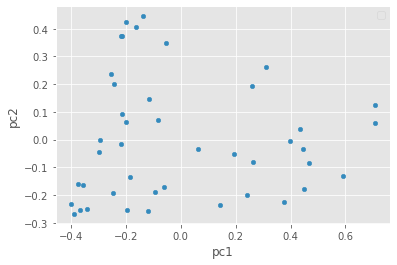

<Figure size 1440x720 with 0 Axes>

In [13]:
df = vectorize(features.values(),features.keys(),'tfidf')
# elbow(df)
pca(df)

{0: ['sugar', 'medicine', 'the', 'turpentine', 'cloth', 'they', 'that', 'with', 'for', 'medicament', 'joint', 'take', 'which', 'but', 'have', 'profit', 'potion', 'this', 'confection', 'company'], 1: ['that', 'his', 'christian', 'ship', 'with', 'have', 'they', 'pleasure', 'for', 'not', 'but', 'the', 'which', 'this', 'will', 'their', 'all', 'company', 'you', 'who']}


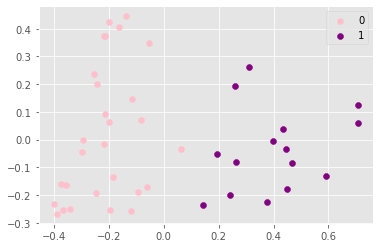

<Figure size 1440x720 with 0 Axes>

In [17]:
k=2
groups,model = cluster(df,features.keys(),k)
sortGroups = sorted(groups.items())
tops = topTerms(model,df,k)
print(tops)
pcaColors(model,df)

In [18]:
for k,v in groups.items(): print(f'Group{k} = {v}')


Group1 = ['A97168', 'A64772', 'A72143', 'A72146', 'A67746', 'A00695', 'A38409', 'A30077', 'A01052', 'A20093', 'A20507', 'A11474', 'A11527', 'A20863', 'A02520', 'A12135', 'A12245', 'A12817', 'A03752', 'A13217', 'A15848', 'A07248', 'A16622', 'A08637', 'A09208', 'A03066', 'A15137', 'A15139']
Group0 = ['A01446', 'A01454', 'A64906', 'A11278', 'A02327', 'A19070', 'A19160', 'A00291', 'A02060', 'A10508', 'A11176', 'A06304', 'A15684', 'A09011', 'A16628']


In [19]:
'''Print documentation for k-means clustering'''
outputStr = []
for k,IDs in sortGroups:
    kWords = []
    tWords = []
    outputStr.append(f'Cluster {k}:')
    for TCPID in IDs:
        kWords.extend(list(kwdict[TCPID][0]))
        tWords.extend(topics[TCPID])
    outputStr.append(f'<br><ul><li><b>TCP IDs:</b> {IDs}</li>')
    outputStr.append(f'<li><b>TFIDF terms:</b> {tops[k]}</li>')
    outputStr.append(f'<li><b>Keywords:</b> {Counter(kWords).most_common(n=10)}</li>')
    outputStr.append(f'<li><b>Topic words:</b> {Counter(tWords).most_common(n=10)}</li></ul>')
print(' '.join(outputStr))

Cluster 0: <br><ul><li><b>TCP IDs:</b> ['A01446', 'A01454', 'A64906', 'A11278', 'A02327', 'A19070', 'A19160', 'A00291', 'A02060', 'A10508', 'A11176', 'A06304', 'A15684', 'A09011', 'A16628']</li> <li><b>TFIDF terms:</b> ['sugar', 'medicine', 'the', 'turpentine', 'cloth', 'they', 'that', 'with', 'for', 'medicament', 'joint', 'take', 'which', 'but', 'have', 'profit', 'potion', 'this', 'confection', 'company']</li> <li><b>Keywords:</b> [('Medicine', 4), ('Diseases', 3), ('Death', 2), ('Life', 2), ('Longevity', 2), ('Plague', 2), ('England', 2), ('Formulae receipts prescriptions', 2), ('Horses', 2), ('Human anatomy', 1)]</li> <li><b>Topic words:</b> [('take', 9), ('good', 6), ('water', 6), ('put', 6), ('body', 5), ('cause', 4), ('use', 4), ('spirit', 3), ('air', 3), ('ounce', 3)]</li></ul> Cluster 1: <br><ul><li><b>TCP IDs:</b> ['A97168', 'A64772', 'A72143', 'A72146', 'A67746', 'A00695', 'A38409', 'A30077', 'A01052', 'A20093', 'A20507', 'A11474', 'A11527', 'A20863', 'A02520', 'A12135', 'A12